In [46]:
import os
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [61]:
# Function for reading the data (hard-coded for now)
def read_data(filename):
    
    _, ext = os.path.splitext(filename)
    
    if ext == '.csv':
        df = pd.read_csv(filename, index_col=0)
    elif ext == '.xls':
        df = pd.read_excel(filename, header=1)
    
    return df

## Read Data

First, we will read the dataset and the data dictionary for the dataset.

In [62]:
# Read 'credit-data.csv'
df = read_data('data/credit-data.csv')

In [63]:
df.shape

(41016, 12)

In [64]:
# data/data-dictionary.xls
data_dict = read_data('data/data-dictionary.xls')

In [158]:
data_dict.head(12)

,Variable Name,Description,Type
0,SeriousDlqin2yrs,Person experienced 90 days past due delinquency or worse,Y/N
1,RevolvingUtilizationOfUnsecuredLines,Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits,percentage
2,age,Age of borrower in years,integer
3,NumberOfTime30-59DaysPastDueNotWorse,Number of times borrower has been 30-59 days past due but no worse in the last 2 years.,integer
4,zipcode,zipcode of the borrower,interget/string
5,DebtRatio,"Monthly debt payments, alimony,living costs divided by monthy gross income",percentage
6,MonthlyIncome,Monthly income,real
7,NumberOfOpenCreditLinesAndLoans,Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards),integer
8,NumberOfTimes90DaysLate,Number of times borrower has been 90 days or more past due.,integer
9,NumberRealEstateLoansOrLines,Number of mortgage and real estate loans including home equity lines of credit,integer


## Exploratory Data Analysis

We will look at distributions of variables, correlations between them, and summarize data.

### The Distribution of the Outcome Variable

The Outcome Variable: __*SeriousDlgin2yrs*__

In [66]:
df['SeriousDlqin2yrs'].value_counts()

0    34396
1    6620 
Name: SeriousDlqin2yrs, dtype: int64

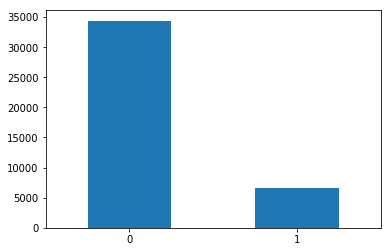

In [178]:
df['SeriousDlqin2yrs'].value_counts().plot('bar', rot=0)
plt.show()

There are an imbalance in the outcome variable. Specifically, there are far more people who experienced 90 days past due delinquency or worse.

### Missing Values

Now we should look at the number of missing values in each column.

In [68]:
def generate_nan_df(df):
    
    nan = df.isna().sum()
    nan_perc = round(100 * nan / len(df.index), 2)
    nan_df = pd.concat([nan, nan_perc], axis=1)
    nan_df = nan_df.rename(columns = {0: 'NaN', 1: 'Percent of NaN'})
    nan_df = nan_df.sort_values(by=['Percent of NaN'], ascending=False)
    
    return nan_df

In [161]:
# Check the missing data
nan_df = generate_nan_df(df)
nan_df.head(12)

,NaN,Percent of NaN
SeriousDlqin2yrs,0,0.0
RevolvingUtilizationOfUnsecuredLines,0,0.0
age,0,0.0
zipcode,0,0.0
NumberOfTime30-59DaysPastDueNotWorse,0,0.0
DebtRatio,0,0.0
MonthlyIncome,0,0.0
NumberOfOpenCreditLinesAndLoans,0,0.0
NumberOfTimes90DaysLate,0,0.0
NumberRealEstateLoansOrLines,0,0.0


- We can see that there are a lot of missing data for __MonthlyIncome__ and __NumberOfDependents__.
- Therefore, we probably do not want to simply drop all missing data.

First, we will look at the distribution of __MonthlyIncome__ and __NumberOfDependents__.

In [176]:
def generate_boxplots(df, columns):
    
    for column in columns:
        
        fig, ax = plt.subplots(figsize=(15, 5))
        ax = sns.boxplot(x=df[column])
        
        # if kurtosis is beyond -3 and 3, log scale the x axis.
        if abs(df[column].kurt()) > 3:
            ax.set_xscale('log')
    
    plt.show()

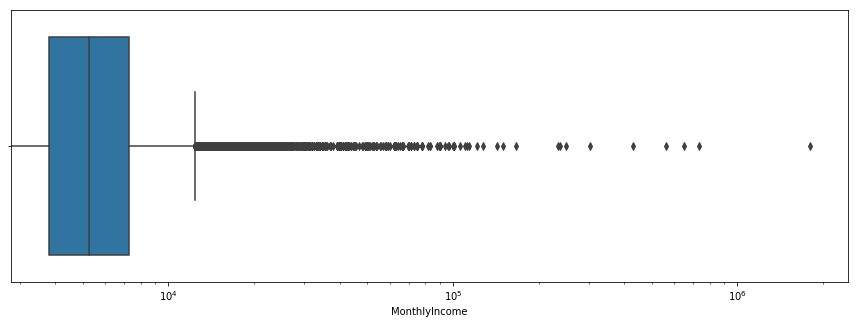

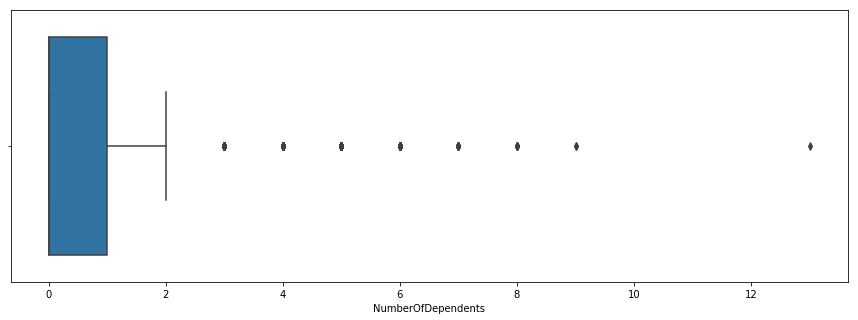

In [177]:
generate_boxplots(df, ['MonthlyIncome', 'NumberOfDependents'])

As we can see from these boxplots, the distribution of __MonthlyIncome__ is very skewed.
- For __MonthlyIncome__, which is very *skewed*, we will use median to impute NaN.
- For __NumberOfDependents__, we will use mean to impute NaN.

In [143]:
def impute_missing_data(df, columns):
    
    for column in columns:
        if abs(df[column].kurt()) > 3:
            cond = df[column].median()
        else:
            cond = df[column].mean()
        estimate = round(cond)
        df[column] = df[column].fillna(estimate)
    
    return df

In [144]:
df = impute_missing_data(df, ['MonthlyIncome', 'NumberOfDependents'])

### Data Types

Since we finally have a complete dataset, we will make sure if the dtype of each columns is correct based on the data dictionary we have.

In [172]:
df.dtypes

SeriousDlqin2yrs                        int64  
RevolvingUtilizationOfUnsecuredLines    float64
age                                     int64  
zipcode                                 int64  
NumberOfTime30-59DaysPastDueNotWorse    int64  
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans         int64  
NumberOfTimes90DaysLate                 int64  
NumberRealEstateLoansOrLines            int64  
NumberOfTime60-89DaysPastDueNotWorse    int64  
NumberOfDependents                      int64  
dtype: object

For most of the columns, the dtype looks like right. However, __NumberOfDependents__ should be in integer; we will change it.

In [173]:
df['NumberOfDependents'] = df['NumberOfDependents'].astype(int)

### Correlations between Variables

Next, we will examine correlations between variables to detect any patterns.

In [174]:
def generate_corr_heatmap(df):

    # compute correlation
    corr = df.corr()
    
    # generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    # create figure and plot
    f, ax = plt.subplots(figsize=(15, 5))
    
    # Generate a diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap=cmap, linewidths=.5)

    plt.show()

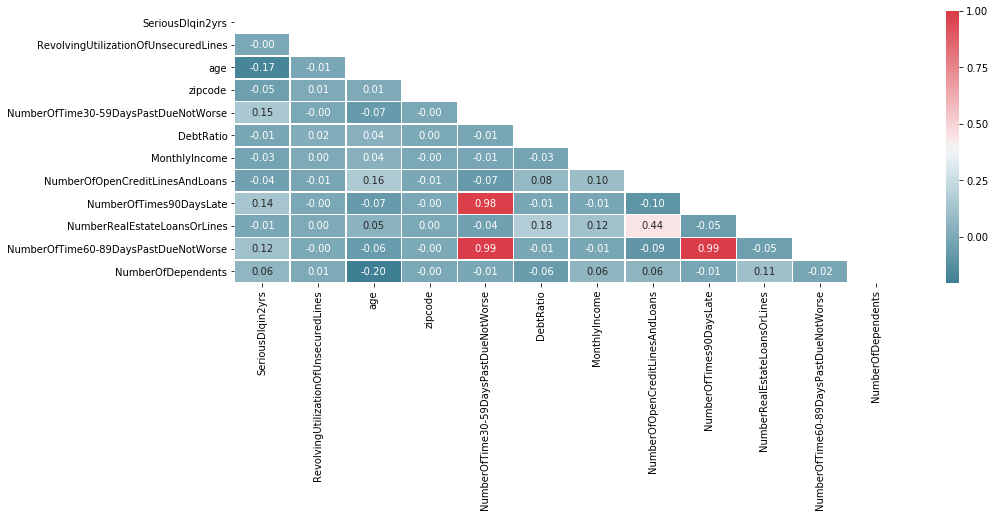

In [175]:
generate_corr_heatmap(df)

From this heatmap, we can see that the following variables:
- __NumberOfTime30-59DaysPastDueNotWorse__,
- __NumberOfTimes90DaysLate__,
- __NumberOfTime60-89DaysPastDueNotWorse__

have extremely high correlations amongst one another (0.98 - 0.99).

We will drop the following variables:
- __NumberOfTime30-59DaysPastDueNotWorse__,
- __NumberOfTime60-89DaysPastDueNotWorse__.

In [179]:
def drop_variables(df, columns):
    
    df = df.drop(labels=columns, axis=1)
    
    return df

In [180]:
unnecessary_vars = ['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse']
df = drop_variables(df, unnecessary_vars)

### Finding Outliers

Next, we will try to find outliers.

In [ ]:
def find_iqr_outliers(df, columns, weight=1.5):
    
    

In [ ]:
g = sns.FacetGrid(df, col='SeriousDlqin2yrs')
g.map(plt.hist, 'age', bins=20)

In [ ]:
g = sns.FacetGrid(df, col='SeriousDlqin2yrs')
g.map(plt.hist, 'NumberofDependents', bins=20)

In [ ]:
df = fill_continuous_na(df, ['MonthlyIncome'])
df = fill_categorical_na(df, ['NumberOfDependents'])

Now we verify that there is no missing data.

In [ ]:
df.isna().sum()

Now that the data seems complete, we should take a closer look at our variables. Specifically, let us have a look at the data dictionary.

In [ ]:
# data/data-dictionary.xls
data_dict = read_data('data/data-dictionary.xls')

In [ ]:
data_dict.head(14)

In [ ]:
df.SeriousDlqin2yrs.value_counts()

In [ ]:
g = sns.FacetGrid(df, col='SeriousDlqin2yrs')
g.map(plt.hist, 'age', bins=20)

In [ ]:
g = sns.FacetGrid(df, col='SeriousDlqin2yrs')
g.map(plt.hist, 'NumberOfDependents', bins=20)

In [ ]:
df.NumberOfDependents.unique()

In [ ]:
estimate